# Introduction

### The goal of current competetion is to predict the car price using provided data. The data contains csv file with characteristics and image files. I will use:
#### * classic ML method(Catboost), tabular NN for tabular data;
#### * NLP NN (LSTM,Convolutional NN, BERT) for text of descriptions;
#### * Computer vision NN (EfficientnetB6) for images;
#### * Ensembling models and blending their predictions.

### At first I will investigate and clean data, then make an EDA and preprocess data to train models on it. During the work I will gather metrics for models to provide them in the end.   

## 1. Loading libraries and writing functions

In [65]:
!pip install -q efficientnet

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [66]:
!pip install transformers==4.10.1

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [67]:
!pip install wget

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [68]:
!pip install pymystem3

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [69]:
!pip install albumentations -q

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [70]:
# Basic libraries
import random
import numpy as np
import pandas as pd
from pandas import Series
pd.options.mode.chained_assignment = None 
import os
import sys
import PIL
import cv2
import re
# ML
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split,KFold
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.feature_selection import f_classif, mutual_info_classif
# keras
import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint,EarlyStopping
from tensorflow.keras.losses import MeanAbsolutePercentageError as MAPE_
from  tensorflow.keras.metrics import RootMeanSquaredError as rmse
import efficientnet.tfkeras as efn # Efficientnet
from transformers import TFBertModel,  BertConfig, BertTokenizerFast
from tensorflow.keras.initializers import TruncatedNormal
# NLP
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from pymystem3 import Mystem
from string import punctuation
# Images
import matplotlib.pyplot as plt
import seaborn as sns
import albumentations
from albumentations import ( HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE,
    RandomRotate90,Transpose, ShiftScaleRotate, Blur, OpticalDistortion,
    GridDistortion, HueSaturationValue,IAAAdditiveGaussianNoise, GaussNoise, 
    MotionBlur, MedianBlur, IAAPiecewiseAffine,IAASharpen, IAAEmboss, 
    RandomBrightnessContrast, Flip, OneOf, Compose)
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline

# Downloading word vectors:
import zipfile
import wget
import gensim
model_url = 'http://vectors.nlpl.eu/repository/20/180.zip'
m = wget.download(model_url)
model_file = model_url.split('/')[-1]
with zipfile.ZipFile(model_file, 'r') as archive:
    stream = archive.open('model.bin')
    word2vec = gensim.models.KeyedVectors.load_word2vec_format(stream, binary=True)

print('Tensorflow   :', tf.__version__)
print('Keras        :', tf.keras.__version__)


Tensorflow   : 2.3.0
Keras        : 2.4.0


In [71]:
'''MAPE function will help to control target metric:'''

def mape_naive(y_true, y_pred):# This is for naive model
    return np.mean(np.abs((y_pred-y_true)/y_true))

def mape(y_true, y_pred):
    y_true = np.exp(y_true)-1 # I will logariphm target,
    y_pred = np.exp(y_pred)-1 # so later it will need to be recovered.
    return round(np.mean(np.abs((y_pred-y_true)/y_true))*100,2)

In [72]:
'''This function will extract quantity of months in "hold" column'''

def get_months(column, pattern):
    new_column = []
    for string in column:
        if string != 0:
            if 'и' in string :
                list = re.findall(pattern, string)
                list = [int(value) for value in list]
                new_column.append(list[0]*12 + list[1])
            elif 'year' in string :
                list = re.findall(pattern, string)
                list = [int(value) for value in list]
                new_column.append(list[0]*12)
            elif 'month' in string :
                list = re.findall(pattern, string)
                list = [int(value) for value in list]
                new_column.append(list[0])
        else: 
            new_column.append(0)
    return new_column

In [73]:
'''Building plots for models'''

def plot_history(history):
    plt.figure(figsize=(10,5))
    plt.style.use('dark_background')
    rmse_ = history.history['root_mean_squared_error']
    val_rmse = history.history['val_root_mean_squared_error']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    plt.plot(epochs, rmse_, 'b', label='Training RMSE')
    plt.plot(epochs, val_rmse, 'g', label='Validation RMSE')
    plt.title('Training and validation RMSE')
    plt.legend()

    plt.figure(figsize=(10,5))   
    plt.plot(epochs, loss, 'b', label='Training MAPE')
    plt.plot(epochs, val_loss, 'g', label='Validation MAPE')
    plt.title('Training and validation MAPE')
    plt.legend()

    plt.show()

In [74]:
"""Dataset functions"""

def process_image(image):
    return augmentation(image = image.numpy())['image']

def tokenize_(descriptions):
    return sequence.pad_sequences(tokenize.texts_to_sequences(descriptions), maxlen = MAX_SEQUENCE_LENGTH)

def tokenize_text(text):
    return tokenize_([text.numpy().decode('utf-8')])[0]

def tf_process_train_dataset_element(image, table_data, text, price):
    im_shape = image.shape
    [image,] = tf.py_function(process_image, [image], [tf.uint8])
    image.set_shape(im_shape)
    [text,] = tf.py_function(tokenize_text, [text], [tf.int32])
    return (image, table_data, text), price

def tf_process_val_dataset_element(image, table_data, text, price):
    [text,] = tf.py_function(tokenize_text, [text], [tf.int32])
    return (image, table_data, text), price

In [75]:
'''Preprocess function for text'''

def preprocess_text(text):
    text = re.sub("[^A-Za-zА-Яа-я]", " ", text)
    tokens = mystem.lemmatize(text.lower())
    tokens = [token for token in tokens if token not in russian_stopwords\
              and token != " " \
              and token.strip() not in punctuation]
    text = " ".join(tokens)
    return text

In [76]:
'''Preparing images to load in model'''

def get_image_array(index):
    images_train = []
    for index, sell_id in enumerate(work['sell_id'].iloc[index].values):
        image = cv2.imread(DATA_DIR + 'img/img/' + str(sell_id) + '.jpg')
        assert(image is not None)
        image = cv2.resize(image, size)
        images_train.append(image)
    images_train = np.array(images_train)
    print('images shape', images_train.shape, 'dtype', images_train.dtype)
    return(images_train)

In [77]:
"""Making augmentations"""

def make_augmentations(images):
    print('применение аугментаций', end = '')
    augmented_images = np.empty(images.shape)
    for i in range(images.shape[0]):
        if i % 200 == 0:
            print('.', end = '')
    augment_dict = augmentation(image = images[i])
    augmented_image = augment_dict['image']
    augmented_images[i] = augmented_image
    print('')
    return augmented_images

In [78]:
'''Fixing random seed and requirements'''

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
!pip freeze > requirements.txt

## 2. Working with data.

In [79]:
'''Loading data'''

DATA_DIR = '../input/sf-dst-car-price-prediction-part2/'
train = pd.read_csv(DATA_DIR + 'train.csv')
test = pd.read_csv(DATA_DIR + 'test.csv')
sample_submission = pd.read_csv(DATA_DIR + 'sample_submission.csv')
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6682 entries, 0 to 6681
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              6682 non-null   object 
 1   brand                 6682 non-null   object 
 2   color                 6682 non-null   object 
 3   description           6682 non-null   object 
 4   engineDisplacement    6682 non-null   object 
 5   enginePower           6682 non-null   object 
 6   fuelType              6682 non-null   object 
 7   mileage               6682 non-null   int64  
 8   modelDate             6682 non-null   int64  
 9   model_info            6682 non-null   object 
 10  name                  6682 non-null   object 
 11  numberOfDoors         6682 non-null   int64  
 12  price                 6682 non-null   float64
 13  productionDate        6682 non-null   int64  
 14  sell_id               6682 non-null   int64  
 15  vehicleConfiguration 

In [80]:
train.describe()

mileage    modelDate  numberOfDoors         price  \
count    6682.000000  6682.000000    6682.000000  6.682000e+03   
mean   120522.610895  2010.135588       4.268482  1.899868e+06   
std     81454.448294     5.370973       0.878687  1.914153e+06   
min         1.000000  1975.000000       2.000000  3.013010e+05   
25%     59181.250000  2007.000000       4.000000  8.000000e+05   
50%    111000.000000  2011.000000       4.000000  1.300000e+06   
75%    168000.000000  2014.000000       5.000000  2.299283e+06   
max    999999.000000  2019.000000       5.000000  2.390000e+07   

       productionDate       sell_id  
count     6682.000000  6.682000e+03  
mean      2012.031577  1.096589e+09  
std          5.049676  2.653747e+07  
min       1982.000000  3.421294e+07  
25%       2009.000000  1.097102e+09  
50%       2013.000000  1.099407e+09  
75%       2016.000000  1.099973e+09  
max       2020.000000  1.100273e+09

In [81]:
train[train['Владельцы'] != train['Владельцы']]# looking for NaN

bodyType brand   color  \
4994    седан  AUDI  чёрный   

                                            description engineDisplacement  \
4994  машина в идеале! вложено примерно 400тыс.руб \...            4.2 LTR   

     enginePower fuelType  mileage  modelDate model_info  ...     price  \
4994     360 N12   бензин   160000       1999         S8  ...  600000.0   

      productionDate     sell_id  vehicleConfiguration  vehicleTransmission  \
4994            2001  1019330519   SEDAN AUTOMATIC 4.2       автоматическая   

     Владельцы            Владение       ПТС  Привод   Руль  
4994       NaN  10 лет и 7 месяцев  Оригинал  полный  Левый  

[1 rows x 22 columns]

In [82]:
train['Владельцы'].value_counts()

3 или более    2646
1 владелец     2029
2 владельца    2006
Name: Владельцы, dtype: int64

In [83]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1671 entries, 0 to 1670
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   bodyType              1671 non-null   object
 1   brand                 1671 non-null   object
 2   color                 1671 non-null   object
 3   description           1671 non-null   object
 4   engineDisplacement    1671 non-null   object
 5   enginePower           1671 non-null   object
 6   fuelType              1671 non-null   object
 7   mileage               1671 non-null   int64 
 8   modelDate             1671 non-null   int64 
 9   model_info            1671 non-null   object
 10  name                  1671 non-null   object
 11  numberOfDoors         1671 non-null   int64 
 12  productionDate        1671 non-null   int64 
 13  sell_id               1671 non-null   int64 
 14  vehicleConfiguration  1671 non-null   object
 15  vehicleTransmission   1671 non-null   

In [84]:
test.describe()

mileage    modelDate  numberOfDoors  productionDate  \
count     1671.000000  1671.000000    1671.000000     1671.000000   
mean    119724.664871  2009.975464       4.236385     2011.927588   
std      83467.240436     5.692836       0.912202        5.332324   
min          1.000000  1971.000000       2.000000     1982.000000   
25%      59373.000000  2007.000000       4.000000     2009.000000   
50%     109000.000000  2011.000000       4.000000     2013.000000   
75%     165375.500000  2014.000000       5.000000     2016.000000   
max    1000000.000000  2019.000000       5.000000     2020.000000   

            sell_id  
count  1.671000e+03  
mean   1.096598e+09  
std    2.673477e+07  
min    3.578222e+07  
25%    1.096977e+09  
50%    1.099404e+09  
75%    1.099984e+09  
max    1.100273e+09

#### Creating common dataset for futher work

In [85]:
'''Let's mark train and test:'''

train['sample'] = 1
test['sample'] = 0
# And join them:
work = train.append(test, ignore_index=True, sort=False)
print(work.info())
work.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8353 entries, 0 to 8352
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              8353 non-null   object 
 1   brand                 8353 non-null   object 
 2   color                 8353 non-null   object 
 3   description           8353 non-null   object 
 4   engineDisplacement    8353 non-null   object 
 5   enginePower           8353 non-null   object 
 6   fuelType              8353 non-null   object 
 7   mileage               8353 non-null   int64  
 8   modelDate             8353 non-null   int64  
 9   model_info            8353 non-null   object 
 10  name                  8353 non-null   object 
 11  numberOfDoors         8353 non-null   int64  
 12  price                 6682 non-null   float64
 13  productionDate        8353 non-null   int64  
 14  sell_id               8353 non-null   int64  
 15  vehicleConfiguration 

bodyType     brand       color  \
7399  внедорожник 5 дв.       BMW       белый   
4273      хэтчбек 5 дв.       BMW      чёрный   
3362  внедорожник 5 дв.  MERCEDES      чёрный   
2794  внедорожник 5 дв.      AUDI  коричневый   
5378              седан  MERCEDES      чёрный   

                                            description engineDisplacement  \
7399  Автодилер года 2020\n\nПобедитель в номинации ...            2.0 LTR   
4273  Продаю а/м БМВ 118i, 136 л.с., 2017 года выпус...            1.5 LTR   
3362  Автомобиль в идеальном состоянии, все исправно...            2.0 LTR   
2794  Автомобиль в отличном  состоянии .Бесключевой ...            2.0 LTR   
5378  Выгода до 82 000 руб. при обмене на Ваш автомо...            4.0 LTR   

     enginePower fuelType  mileage  modelDate    model_info  ...  \
7399     177 N12   дизель   144437       2009            X1  ...   
4273     136 N12   бензин    56094       2015           1ER  ...   
3362     211 N12   бензин   133000       2012    GLK_KLASSE  ...   
2794     225 N12   бензин   112584       2012            Q5  ...   
5378     612 N12   бензин    16562       2016  E_KLASSE_AMG  ...   

     productionDate     sell_id             vehicleConfiguration  \
7399           2011  1099879366    ALLROAD_5_DOORS AUTOMATIC 2.0   
4273           2017  1100201582  HATCHBACK_5_DOORS AUTOMATIC 1.5   
3362           2013  1099378480    ALLROAD_5_DOORS AUTOMATIC 2.0   
2794           2014  1099193782    ALLROAD_5_DOORS AUTOMATIC 2.0   
5378           2018  1099976030              SEDAN AUTOMATIC 4.0   

      vehicleTransmission    Владельцы Владение       ПТС  Привод   Руль  \
7399       автоматическая  2 владельца      NaN  Оригинал  полный  Левый   
4273       автоматическая   1 владелец      NaN  Оригинал  задний  Левый   
3362       автоматическая  2 владельца      NaN  Оригинал  полный  Левый   
2794       автоматическая  2 владельца      NaN  Оригинал  полный  Левый   
5378       автоматическая  2 владельца      NaN  Оригинал  полный  Левый   

     sample  
7399      0  
4273      1  
3362      1  
2794      1  
5378      1  

[5 rows x 23 columns]

In [86]:
'''Rename columns for convenient working:'''

work.columns = ['body', 'brand', 'color', 'description', 'volume',
       'power', 'fuel', 'km', 'model_date', 'model', 'name',
       'doors', 'price', 'prod_date', 'sell_id',
       'vehicleConfiguration', 'trans', 'owners', 'hold','pts',
       'drive', 'wheel', 'sample']


In [87]:
''' As we can see below, columns "name" and "vehicleConfiguration"
does not contain any additional information, so I will drop them out'''

display(work[['body', 'volume','power', 'fuel', 'km', 'model_date', 'model', 'name',
       'doors', 'vehicleConfiguration', 'trans','drive','wheel']]) 
work.drop(['name','vehicleConfiguration'],axis = 1, inplace = True)

body   volume    power    fuel      km  model_date  \
0                 седан  3.0 LTR  272 N12  бензин  245000        2007   
1                 седан  2.8 LTR  204 N12  бензин  183000        2011   
2                 седан  3.5 LTR  306 N12  бензин  122733        2009   
3                 седан  2.0 LTR  180 N12  бензин  151000        2011   
4               лифтбек  1.8 LTR  160 N12  бензин  140000        2007   
...                 ...      ...      ...     ...     ...         ...   
8348              седан  2.0 LTR  184 N12  бензин   76000        2011   
8349  внедорожник 5 дв.  3.0 LTR  218 N12  дизель  120381        2013   
8350  внедорожник 5 дв.  1.4 LTR  150 N12  бензин   25790        2014   
8351              седан  2.0 LTR  184 N12  бензин  104000        2009   
8352              седан  2.0 LTR  225 N12  бензин  112434        2011   

         model                         name  doors  \
0          5ER  530xi 3.0 AT (272 л.с.) 4WD      4   
1           A6           2.8 CVT (204 л.с.)      4   
2     E_KLASSE    350 3.5 AT (306 л.с.) 4WD      4   
3           A6           2.0 CVT (180 л.с.)      4   
4           A5           1.8 CVT (160 л.с.)      5   
...        ...                          ...    ...   
8348       3ER       320i 2.0 AT (184 л.с.)      4   
8349        X5   25d 3.0d AT (218 л.с.) 4WD      5   
8350        Q3           1.4 AMT (150 л.с.)      5   
8351       5ER       520i 2.0 AT (184 л.с.)      4   
8352        A4       2.0 AMT (225 л.с.) 4WD      4   

               vehicleConfiguration             trans     drive  wheel  
0               SEDAN AUTOMATIC 3.0    автоматическая    полный  Левый  
1                SEDAN VARIATOR 2.8          вариатор  передний  Левый  
2               SEDAN AUTOMATIC 3.5    автоматическая    полный  Левый  
3                SEDAN VARIATOR 2.0          вариатор  передний  Левый  
4             LIFTBACK VARIATOR 1.8          вариатор  передний  Левый  
...                             ...               ...       ...    ...  
8348            SEDAN AUTOMATIC 2.0    автоматическая    задний  Левый  
8349  ALLROAD_5_DOORS AUTOMATIC 3.0    автоматическая    полный  Левый  
8350      ALLROAD_5_DOORS ROBOT 1.4  роботизированная  передний  Левый  
8351            SEDAN AUTOMATIC 2.0    автоматическая    задний  Левый  
8352                SEDAN ROBOT 2.0  роботизированная    полный  Левый  

[8353 rows x 13 columns]

In [88]:
work.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8353 entries, 0 to 8352
Data columns (total 21 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   body         8353 non-null   object 
 1   brand        8353 non-null   object 
 2   color        8353 non-null   object 
 3   description  8353 non-null   object 
 4   volume       8353 non-null   object 
 5   power        8353 non-null   object 
 6   fuel         8353 non-null   object 
 7   km           8353 non-null   int64  
 8   model_date   8353 non-null   int64  
 9   model        8353 non-null   object 
 10  doors        8353 non-null   int64  
 11  price        6682 non-null   float64
 12  prod_date    8353 non-null   int64  
 13  sell_id      8353 non-null   int64  
 14  trans        8353 non-null   object 
 15  owners       8352 non-null   object 
 16  hold         2935 non-null   object 
 17  pts          8353 non-null   object 
 18  drive        8353 non-null   object 
 19  wheel 

## Column description:

* body - body of the car : coupe, hatchback etc. 
* brand - car brand : mercedes, bmw etc.
* color - just color
* description - owners description
* volume - volume of the car's engine
* power - power in horse powers
* fuel - type of fuel : gas, petrol, diesel ...
* km - distance that car have passed
* model_date - date of model's creeation
* model - car model : elantra, almera etc.
* doors - number of doors
* price - this is the target variable, cost of the car
* prod_date - manufacture year
* sell_id - unique id, will be used for submission and images
* trans - transmission type: manual,auto ... 
* owners - how many owners have used the car
* hold - how long does the seller owns the car
* pts - passport of the car
* drive - the car's drive unit : front-wheel, 4X4 ...
* wheel - wheel position : left or right
* sample - mark of train and test values



## 3. Working with features

### Body

In [89]:
print(work.body.unique())

['седан' 'лифтбек' 'внедорожник 5 дв.' 'хэтчбек 5 дв.' 'минивэн'
 'универсал 5 дв.' 'купе-хардтоп' 'купе' 'кабриолет' 'родстер'
 'хэтчбек 3 дв.' 'компактвэн' 'пикап двойная кабина'
 'внедорожник открытый' 'седан 2 дв.' 'внедорожник 3 дв.' 'лимузин']


In [90]:
"""As we have a separate column 'doors', it will be
better to drop this info from 'body' """

work.body = work.body.replace('универсал 5 дв.','универсал')
work.body = work.body.replace(['внедорожник 5 дв.',
                               'внедорожник открытый',
                               'внедорожник 3 дв.'],'внедорожник')
work.body = work.body.replace(['хэтчбек 5 дв.','хэтчбек 3 дв.'],'хэтчбек')
work.body = work.body.replace('седан 2 дв.','седан')


In [91]:
print(work.body.unique())

['седан' 'лифтбек' 'внедорожник' 'хэтчбек' 'минивэн' 'универсал'
 'купе-хардтоп' 'купе' 'кабриолет' 'родстер' 'компактвэн'
 'пикап двойная кабина' 'лимузин']


### Ages and usage

In [92]:
''' Creating a new features "model_age" and "car_age"'''

work['model_age']=2021-work.model_date
work['car_age']=2021-work.model_date

In [93]:
'''This feature will show us the Exploitation degree of each car:'''

work['usage'] = work.km/work.car_age
work.usage = work.usage.apply(lambda x:int(x))

### Volume

In [94]:
work.volume.unique()

array(['3.0 LTR', '2.8 LTR', '3.5 LTR', '2.0 LTR', '1.8 LTR', '5.5 LTR',
       '2.5 LTR', '1.6 LTR', '1.5 LTR', '4.8 LTR', '4.4 LTR', '3.8 LTR',
       '2.2 LTR', '4.0 LTR', '2.1 LTR', '2.4 LTR', '4.7 LTR', '1.2 LTR',
       '3.6 LTR', '3.1 LTR', '0.7 LTR', '6.0 LTR', '4.1 LTR', '5.0 LTR',
       '5.4 LTR', '6.2 LTR', '4.2 LTR', '1.4 LTR', '2.9 LTR', '1.7 LTR',
       '3.2 LTR', '2.7 LTR', '1.9 LTR', '1.3 LTR', '5.2 LTR', '3.7 LTR',
       '5.9 LTR', '4.9 LTR', '2.3 LTR', '6.6 LTR', '3.4 LTR', '6.3 LTR',
       '2.6 LTR', 'undefined LTR', '5.6 LTR', '4.3 LTR', '4.6 LTR',
       '5.8 LTR'], dtype=object)

In [95]:
'''Converting to integet'''

work.volume = pd.to_numeric(work.volume.apply(lambda x:x.split(' ')[0]),errors = 'coerce') 
work.volume = work.volume.fillna(work.volume.median())

In [96]:
work.volume.unique()

array([3. , 2.8, 3.5, 2. , 1.8, 5.5, 2.5, 1.6, 1.5, 4.8, 4.4, 3.8, 2.2,
       4. , 2.1, 2.4, 4.7, 1.2, 3.6, 3.1, 0.7, 6. , 4.1, 5. , 5.4, 6.2,
       4.2, 1.4, 2.9, 1.7, 3.2, 2.7, 1.9, 1.3, 5.2, 3.7, 5.9, 4.9, 2.3,
       6.6, 3.4, 6.3, 2.6, 5.6, 4.3, 4.6, 5.8])

### Power

In [97]:
work.power.unique()

array(['272 N12', '204 N12', '306 N12', '180 N12', '160 N12', '184 N12',
       '197 N12', '326 N12', '190 N12', '245 N12', '224 N12', '585 N12',
       '211 N12', '225 N12', '218 N12', '156 N12', '231 N12', '238 N12',
       '140 N12', '150 N12', '360 N12', '122 N12', '555 N12', '249 N12',
       '95 N12', '136 N12', '163 N12', '407 N12', '469 N12', '388 N12',
       '544 N12', '177 N12', '170 N12', '455 N12', '105 N12', '280 N12',
       '367 N12', '340 N12', '400 N12', '233 N12', '265 N12', '450 N12',
       '333 N12', '290 N12', '300 N12', '192 N12', '143 N12', '390 N12',
       '269 N12', '408 N12', '240 N12', '200 N12', '320 N12', '258 N12',
       '435 N12', '115 N12', '120 N12', '558 N12', '235 N12', '476 N12',
       '525 N12', '279 N12', '420 N12', '239 N12', '575 N12', '422 N12',
       '507 N12', '193 N12', '605 N12', '116 N12', '271 N12', '220 N12',
       '310 N12', '102 N12', '355 N12', '350 N12', '210 N12', '82 N12',
       '462 N12', '125 N12', '313 N12', '557 N12', '2

In [98]:
'''Converting to integer'''

work.power = pd.to_numeric(work.power.apply(lambda x:x.split(' ')[0]),errors = 'coerce') 
work.power.unique()

array([272, 204, 306, 180, 160, 184, 197, 326, 190, 245, 224, 585, 211,
       225, 218, 156, 231, 238, 140, 150, 360, 122, 555, 249,  95, 136,
       163, 407, 469, 388, 544, 177, 170, 455, 105, 280, 367, 340, 400,
       233, 265, 450, 333, 290, 300, 192, 143, 390, 269, 408, 240, 200,
       320, 258, 435, 115, 120, 558, 235, 476, 525, 279, 420, 239, 575,
       422, 507, 193, 605, 116, 271, 220, 310, 102, 355, 350, 210,  82,
       462, 125, 313, 557, 264, 530, 329, 250, 510, 130, 194, 612, 571,
       517, 335, 118, 255, 286, 110, 372, 500, 230, 381, 430, 560, 296,
       260, 639, 550, 299, 129, 252, 625, 610, 401, 394, 402, 445, 316,
       109, 330, 600, 292, 431, 354, 520, 100, 113, 242, 370, 609, 626,
       457,  75, 256, 347, 223, 215,  98, 487, 270, 114, 480, 234, 514,
       165, 174, 580, 421, 132, 591, 166, 321, 101, 700, 133])

### Owners and hold

In [99]:
'''Converting to integer'''

work.owners = pd.to_numeric(work.owners.apply(lambda x: x[0] if x==x else x))

In [100]:
'''Looking at NaN'''

work[work.owners != work.owners ]

body brand   color                                        description  \
4994  седан  AUDI  чёрный  машина в идеале! вложено примерно 400тыс.руб \...   

      volume  power    fuel      km  model_date model  ...           trans  \
4994     4.2    360  бензин  160000        1999    S8  ...  автоматическая   

      owners                hold       pts   drive  wheel sample model_age  \
4994     NaN  10 лет и 7 месяцев  Оригинал  полный  Левый      1        22   

     car_age usage  
4994      22  7272  

[1 rows x 24 columns]

#### We see, that last owner holded this car for 10 years and the production date of car is 2001, so I can say with sufficient confidence, that car had more than one owner. 

In [101]:
'''The mean value:'''

work.owners.mean()

2.0939894636015324

In [102]:
'''Inputing investigated value'''

work[work.owners != work.owners ] = 2

In [103]:
work.hold[work.hold == 0] # There are no zeroes in column

Series([], Name: hold, dtype: object)

In [104]:
'''Filling NaNs with zeroes '''

work.hold = work.hold.fillna(0)

In [105]:
display(work[work.hold == 2]) # This is a mistake, it must to be dropped
work.drop(4994,inplace = True)
work.reset_index(drop = True, inplace = True)

body brand color description  volume  power fuel  km  model_date model  \
4994    2     2     2           2     2.0      2    2   2           2     2   

      ...  trans  owners  hold  pts drive  wheel sample model_age car_age  \
4994  ...      2     2.0     2    2     2      2      2         2       2   

     usage  
4994     2  

[1 rows x 24 columns]

In [106]:
'''Splitting months and years'''

work.hold = work.hold.apply(lambda x: re.sub(r'[гл]\w+','year',x) if type(x) == str else x)
work.hold = work.hold.apply(lambda x: re.sub(r'меся\w+','month',x) if type(x) == str else x)

In [107]:
'''Coverting to years amount'''

work.hold = get_months(work.hold, re.compile('\d+'))# extract months
work.hold = work.hold/12# convert to years
# Filling empty values with the ratio of car age to owners amount:
work.hold[work.hold == 0] = work.car_age[work.hold == 0]/work.owners[work.hold == 0]
work.hold = work.hold.apply(lambda x:round(x,2))
work.hold .sample(10)

7472    2.00
3919    2.17
5450    4.00
3844    5.67
3233    2.25
5154    5.50
3245    1.67
7588    2.50
728     5.67
2014    5.00
Name: hold, dtype: float64

#### 

In [108]:
'''Sorting columns'''

work = work[[ 'brand', 'model','body', 'color','model_date','model_age','prod_date','car_age','km','usage','volume', 'power', 'fuel',
         'doors','trans', 'drive', 'wheel','owners','hold','pts', 'description', 'sell_id','price','sample']]
work.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8352 entries, 0 to 8351
Data columns (total 24 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   brand        8352 non-null   object 
 1   model        8352 non-null   object 
 2   body         8352 non-null   object 
 3   color        8352 non-null   object 
 4   model_date   8352 non-null   int64  
 5   model_age    8352 non-null   int64  
 6   prod_date    8352 non-null   int64  
 7   car_age      8352 non-null   int64  
 8   km           8352 non-null   int64  
 9   usage        8352 non-null   int64  
 10  volume       8352 non-null   float64
 11  power        8352 non-null   int64  
 12  fuel         8352 non-null   object 
 13  doors        8352 non-null   int64  
 14  trans        8352 non-null   object 
 15  drive        8352 non-null   object 
 16  wheel        8352 non-null   object 
 17  owners       8352 non-null   float64
 18  hold         8352 non-null   float64
 19  pts   

### Numeric features

In [109]:
'''Defining attributes for a numeric data group'''

num_cols=['model_date','model_age','prod_date','car_age',
          'km','usage','volume','power', 'hold']

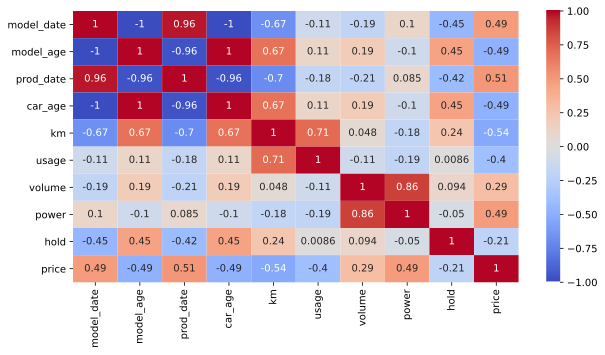

In [110]:
'''Constructing the correlation matrix'''

plt.figure(figsize=(10,5))
sns.heatmap(work[num_cols+['price']].corr(), annot=True,cmap='coolwarm')

In [111]:
"""Dropping high correlative features:"""

work['age'] = work['car_age']
work.drop(['model_date','model_age',
           'prod_date','car_age'],axis = 1, inplace = True)
work = work[[ 'brand', 'model','body', 'color','age','km','usage','volume', 'power', 'fuel',
         'doors','trans', 'drive', 'wheel','owners','hold', 'pts', 'description', 'sell_id','price','sample']]

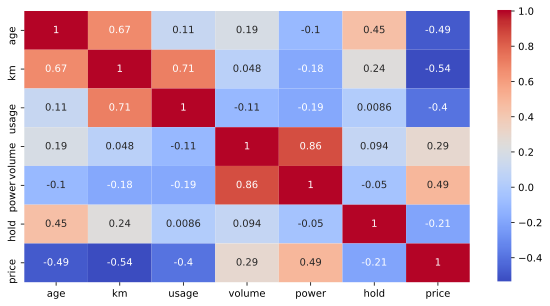

In [112]:
'''Defining attributes for a numeric data group'''

num_cols=['age','km','usage','volume','power','hold']
# Constructing the correlation matrix:
plt.figure(figsize=(10,5))
sns.heatmap(work[num_cols+['price']].corr(), annot=True,cmap='coolwarm')

In [113]:
'''Defining attributes for categorial data group '''

bin_cols = ['pts','wheel']
cat_cols = ['brand','model','body','color','fuel','doors','trans','drive','owners']



## 4. Model 1: Naive
This model will predict the average price by using only the model name and age.
It's a start point to compare with other models. 



In [114]:
'''Split data'''

data_train, data_test = train_test_split(work[work['sample'] == 1][['model', 'age','price']],
                                         test_size=0.15, shuffle=True,
                                         random_state=RANDOM_SEED)

# Naive model
predicts = []
for index, row in pd.DataFrame(data_test[['model', 'age']]).iterrows():
    query = f"model == '{row[0]}' and age == '{row[1]}'"
    predicts.append(data_train.query(query)['price'].median())
# fill missing overlaps
predicts = pd.DataFrame(predicts)
predicts = predicts.fillna(predicts.median())
# round
predicts = (predicts // 1000) * 1000
# Checking the MAPE
print(f" MAPE: {(mape_naive(data_test['price'], predicts.values[:, 0]))*100:0.2f}%")

 MAPE: 18.85%


##### Here we can see, that MAPE has reduced from 19.88% in compare with baseline
##### This means, that the "age" feature is working better, than "product_date". 

## 5. Exploratory data analysis

In [115]:
'''Building graphs of target variable dependency from numeric features:'''

y = work[work['sample'] == 1].price
X = work[work['sample'] == 1][num_cols]
fig, axs = plt.subplots(figsize=(10, 8), ncols=3,nrows =2)
for i, feature in enumerate(num_cols[0:3]):
    axs[0][i].scatter(X[feature], y, alpha=0.2)
    axs[0][i].set_xlabel(feature)
    axs[0][i].set_ylabel("price")
for i, feature in enumerate(num_cols[3:]):   
    axs[1][i].scatter(X[feature], y, alpha=0.2)
    axs[1][i].set_xlabel(feature)
    axs[1][i].set_ylabel("price") 


plt.tight_layout()

#### Price is directry dependent from volume and power
#### Price is inversaly dependent from distance, age,usage and hold.

Text(0.5, 0, 'F-value')

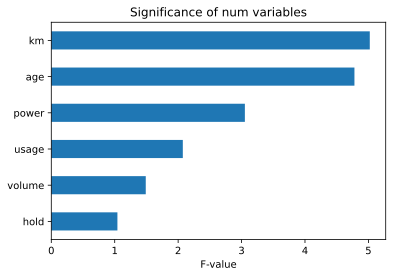

In [116]:
'''Significance of num variables'''

imp_num = Series(f_classif(work[work['sample'] == 1][num_cols],
                           work[work['sample'] == 1]['price'])[0],
                           index = num_cols
                           )
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')
plt.title('Significance of num variables')
plt.xlabel('F-value')

In [117]:
'''Dataframe to draw significance graph for cat and bin features:'''

work_sign = work.copy() 
for column in bin_cols:
     work_sign[column] = LabelEncoder().fit_transform(work_sign[column])
for column in cat_cols:
     work_sign[column] = LabelEncoder().fit_transform(work_sign[column])

Text(0.5, 1.0, 'Significance of cat variables')

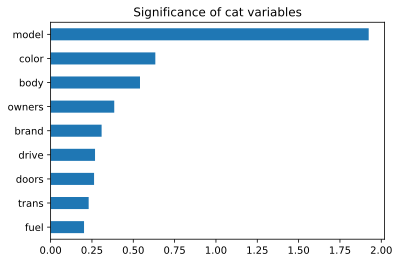

In [118]:
'''Significance of cat variables'''
imp_cat = Series(mutual_info_classif(work_sign[work_sign['sample'] == 1][cat_cols],
                                     work_sign[work_sign['sample'] == 1]['price'],
                                     discrete_features =True),
                                     index = cat_cols
                                     )
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')
plt.title('Significance of cat variables')

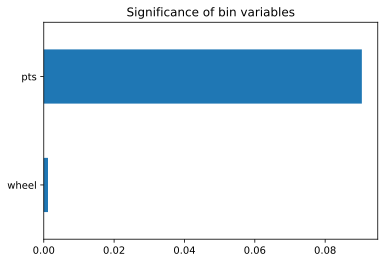

In [119]:
'''Significance of bin variables'''

imp_bin = Series(mutual_info_classif(work_sign[work_sign['sample'] == 1][bin_cols],
                                     work_sign[work_sign['sample'] == 1]['price'],
                                     discrete_features =True),
                                     index = bin_cols
                                     )
imp_bin.sort_values(inplace = True)
imp_bin.plot(kind = 'barh')
plt.title('Significance of bin variables')
del work_sign

In [120]:
'''It is not neccesary to keep "wheel" column anymore:'''

print(work.wheel.value_counts())
work.drop('wheel',axis = 1,inplace = True)

Левый     8350
Правый       2
Name: wheel, dtype: int64


## 6. Data preprocessing

In [121]:
'''Transforming binary variables:'''

work['pts'] = LabelEncoder().fit_transform(work['pts'])
# Model can read only numbers,so now our bins is zero an one:
work['pts'].sample(5)

104     1
3884    1
207     1
4420    1
5371    1
Name: pts, dtype: int64

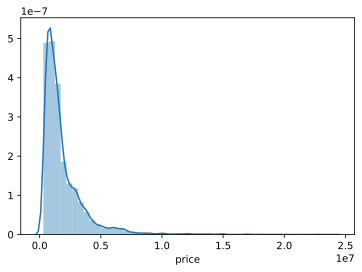

In [122]:
'''Building graphic of the target variable distirbution:'''

sns.distplot(work.price)#

#### We can see high distribution bias, so it needs to be normalized.

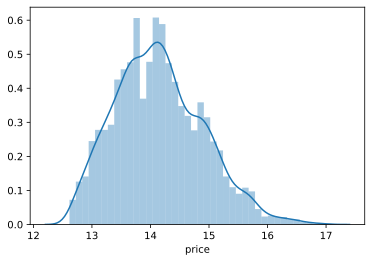

In [123]:
'''Normalazing price'''

work.price = np.log(work.price + 1)
sns.distplot(work.price)

#### Now we can see a pretty good normalization

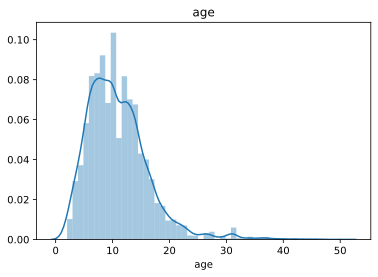

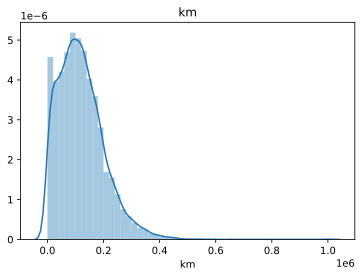

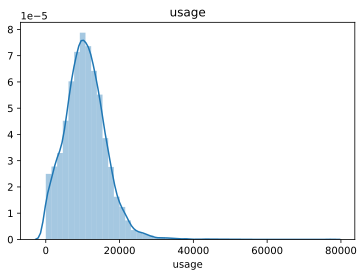

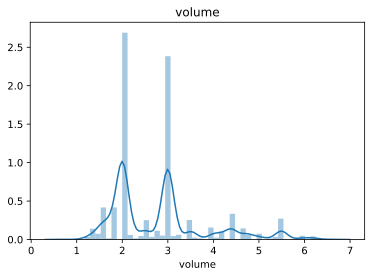

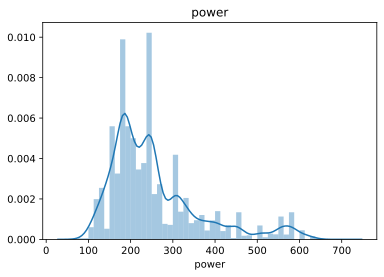

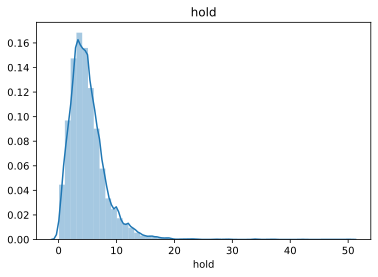

In [124]:
'''Now we need to draw some graphs, to check the distribution:'''

for i in num_cols:
    plt.figure()
    sns.distplot(work[i])
    plt.title(i)
    plt.show()

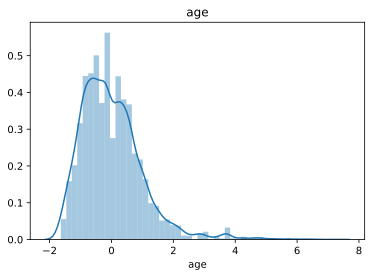

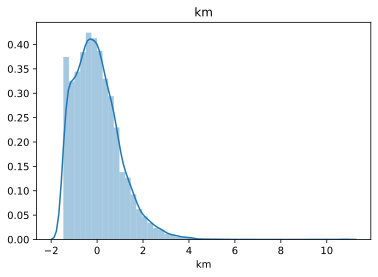

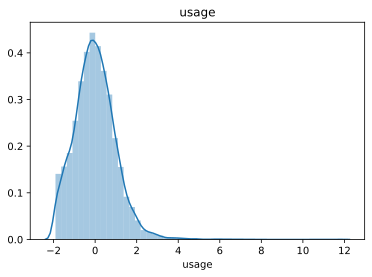

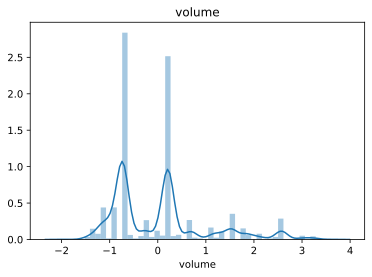

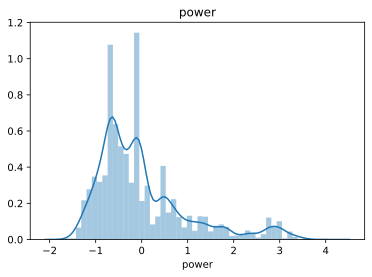

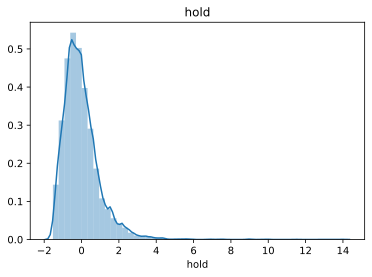

In [125]:
'''Standardizing values:'''

scaler = StandardScaler()
for column in num_cols:
    work[column] = scaler.fit_transform(work[[column]])[:,0]

for i in num_cols:
    plt.figure()
    sns.distplot(work[i])
    plt.title(i)
    plt.show()

In [126]:
work[num_cols].sample(5)

age        km     usage    volume     power      hold
5527  0.939165  0.060860 -0.517137 -0.738295 -0.914305  0.094191
7733 -0.716599 -0.504038  0.098821 -1.117255 -0.914305 -1.301544
4429  0.387244  1.095122  0.961020  0.398584  0.141925  0.457083
2494 -1.452494 -1.409291 -1.612785 -1.306735 -0.969412 -1.403898
1821 -0.164678  0.374340  0.773941 -0.738295 -0.693874 -0.938653

In [127]:
'''Encoding categorical features:'''

work = pd.get_dummies(work, columns=cat_cols, dummy_na=False)
work.sample(5)

age        km     usage    volume     power      hold  pts  \
7196  1.123139 -0.004376 -0.654826 -1.306735 -1.199028  1.077410    1   
2813  0.387244  0.056707 -0.200541 -0.738295 -0.693874 -1.534167    1   
2460  1.123139  0.428814 -0.284221  2.103902  2.309492  0.199647    1   
695  -0.716599 -1.224820 -1.398701  1.535462  2.934045  0.612164    1   
7862 -0.532625  0.012763  0.787265 -0.738295 -0.657136 -0.318326    1   

                                            description     sell_id  \
7196  На автомобиле ездила девушка, есть сколы, небо...  1094869308   
2813  Продаётся авто в хорошем состоянии, два владел...  1099941402   
2460  Автомобиль продаётся официальным дилером BMW -...  1099050266   
695   Автомобиль из демонстрационного парка по спец ...  1097795466   
7862  Комфорт: 8. Безопасность: 6. Мультимедиа: 3. О...  1100048826   

          price  ...  trans_автоматическая  trans_вариатор  \
7196        NaN  ...                     0               0   
2813  13.764218  ...                     1               0   
2460  14.151984  ...                     0               0   
695   15.516614  ...                     1               0   
7862        NaN  ...                     1               0   

      trans_механическая  trans_роботизированная  drive_задний  \
7196                   0                       1             0   
2813                   0                       0             0   
2460                   0                       1             1   
695                    0                       0             0   
7862                   0                       0             1   

      drive_передний  drive_полный  owners_1.0  owners_2.0  owners_3.0  
7196               1             0           0           1           0  
2813               0             1           0           1           0  
2460               0             0           0           0           1  
695                0             1           1           0           0  
7862               0             0           0           1           0  

[5 rows x 183 columns]

In [128]:
'''Let's separate train and test data'''

train_data = work.query('sample == 1').drop(['sample','description','sell_id'], axis=1)
test_data  = work.query('sample == 0').drop(['sample','description','sell_id'], axis=1)

y = train_data.price    # our target
X = train_data.drop(['price'], axis=1)
X_sub = test_data .drop(['price'], axis=1)

In [129]:
'''Copying data for BERT'''

work_b = work[['description','price','sample']]
work_b

description      price  sample
0     Авто на бодром ходу.  Все работает отлично.  П...  13.303019       1
1     Продажа от собственника, второй владелец, ПТС ...  13.652993       1
2     Внимание! Только для клиентов AVILON Автомобил...  14.096924       1
3     В комплекте зимние колёса. 27.07.2020 Замена п...  13.610945       1
4     Отличный авто, 2011 года выпуска, кроме передн...  13.604791       1
...                                                 ...        ...     ...
8347  Продаётся любимица семьи. Автомобилем неактивн...        NaN       0
8348  В продаже автомобиль от компании АО ABTODOM, о...        NaN       0
8349  Машина в идеальном техническом состоянии. Обсл...        NaN       0
8350  Автомобиль приобретался новым у дилера Avilon ...        NaN       0
8351  ID: 38887\nКомплектация-Comfort\nГод выпуска в...        NaN       0

[8352 rows x 3 columns]

## 7. Model 2: CatBoostRegressor

In [130]:
'''Splitting data'''

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.15, 
                                                    shuffle=True, 
                                                    random_state=RANDOM_SEED)

In [131]:
'''Taraining CatBoost'''

model = CatBoostRegressor(iterations = 5000,
                          #depth=10,
                          learning_rate = 0.01,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['RMSE', 'MAE'],
                          od_wait=500,
                          #task_type='GPU',
                         )
model.fit(X_train, y_train,
         eval_set=(X_test, y_test),
         verbose_eval=100,
         use_best_model=True,
         #plot=True
         )

0:	learn: 0.0422455	test: 0.0427779	best: 0.0427779 (0)	total: 54.2ms	remaining: 4m 30s
100:	learn: 0.0217851	test: 0.0217484	best: 0.0217484 (100)	total: 389ms	remaining: 18.9s
200:	learn: 0.0149711	test: 0.0148745	best: 0.0148745 (200)	total: 706ms	remaining: 16.8s
300:	learn: 0.0125875	test: 0.0124977	best: 0.0124977 (300)	total: 1.02s	remaining: 15.9s
400:	learn: 0.0116080	test: 0.0114896	best: 0.0114896 (400)	total: 1.32s	remaining: 15.2s
500:	learn: 0.0111077	test: 0.0109980	best: 0.0109980 (500)	total: 1.62s	remaining: 14.6s
600:	learn: 0.0107955	test: 0.0107111	best: 0.0107111 (600)	total: 1.92s	remaining: 14.1s
700:	learn: 0.0105855	test: 0.0105475	best: 0.0105475 (699)	total: 2.22s	remaining: 13.6s
800:	learn: 0.0103562	test: 0.0103717	best: 0.0103717 (800)	total: 2.52s	remaining: 13.2s
900:	learn: 0.0101876	test: 0.0102571	best: 0.0102571 (900)	total: 2.81s	remaining: 12.8s
1000:	learn: 0.0100678	test: 0.0101741	best: 0.0101741 (1000)	total: 3.1s	remaining: 12.4s
1100:	learn

In [132]:
test_predict_cat = model.predict(X_test)
print("TEST MAPE:", mape(y_test, test_predict_cat))

TEST MAPE: 13.12


#### Submission

In [133]:
sub_predict_catboost = model.predict(X_sub)
sample_submission['price'] =np.exp(sub_predict_catboost)-1
sample_submission.to_csv('catboost_submission.csv', index=False)

### Catboost with cross-validation

In [134]:
'''Ising K-fold validation'''

submissions_cat = pd.DataFrame(0,columns=["sub_1"], index=sample_submission.sell_id)

mape_per_fold = []

kfold = KFold(n_splits=5, shuffle=True)

fold_no = 1

for train, test in kfold.split(X, y):
    print('-'*32)
    print(f'Training for fold {fold_no} ...')
    
    model.fit(train_data.drop(['price'], axis=1).iloc[train],
              train_data['price'].iloc[train],
              eval_set=(train_data.drop(['price'], axis=1).iloc[test],
                        train_data['price'].iloc[test]),
              use_best_model=True,
              silent=True,
             )
    
    predict = model.predict(train_data.drop(['price'], axis=1).iloc[test])
    print('Test MAPE:', mape(train_data['price'].iloc[test], predict))
    mape_per_fold.append(mape(train_data['price'].iloc[test],predict))
    submissions_cat[f'sub_{fold_no}'] = np.exp(model.predict(X_sub))-1                      
    fold_no += 1
    
print('-'*32)
print('Average scores for all folds:')
print(f'MAPE: {np.mean(mape_per_fold)} (+- {np.std(mape_per_fold)})')
print('-'*32) 



--------------------------------
Training for fold 1 ...
Test MAPE: 12.77
--------------------------------
Training for fold 2 ...
Test MAPE: 12.61
--------------------------------
Training for fold 3 ...
Test MAPE: 12.54
--------------------------------
Training for fold 4 ...
Test MAPE: 12.84
--------------------------------
Training for fold 5 ...
Test MAPE: 13.96
--------------------------------
Average scores for all folds:
MAPE: 12.943999999999999 (+- 0.5192533100520406)
--------------------------------


In [135]:
submissions_cat['cross'] = (submissions_cat.sum(axis=1))/len(submissions_cat.columns)
sample_submission['price'] = submissions_cat['cross'].values
sample_submission.to_csv(f'cat_cv_submission.csv', index=False)

## 8. Model 3: Tabular NN

#### Simple Dense NN

In [136]:
'''Assembling model:'''

model = Sequential()
model.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu"))
model.add(L.Dropout(0.35))
model.add(L.Dense(256, activation="relu"))
model.add(L.Dropout(0.1))
model.add(L.Dense(1, activation="linear"))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               92160     
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 223,745
Trainable params: 223,745
Non-trainable params: 0
_________________________________________________________________


In [137]:
'''Compile'''

LR=0.01
optimizer = tf.keras.optimizers.Adam(lr=LR)
model.compile(loss='MAPE',optimizer=optimizer, metrics=[rmse()])

In [138]:
'''Making callbacks:'''

checkpoint = ModelCheckpoint('best_model.hdf5' , monitor = ['val_loss'] ,
                              verbose = 0  , mode = 'min')

# Stop the education if the is no progress:
earlystop = EarlyStopping(monitor='val_loss', patience=15,verbose=1,mode='min',
                          restore_best_weights=True)

# Reduce learning rate if the is no progress:
reduce_lr = ReduceLROnPlateau( monitor='val_loss',factor=0.25,patience=5,
                               min_lr=1e-10,verbose=0,mode='min')

callbacks_list = [checkpoint, earlystop,reduce_lr]

### Fit

In [139]:
history = model.fit(X_train, y_train,
                    batch_size=512,
                    epochs=200, # waiting for EarlyStopping 
                    validation_data=(X_test, y_test),
                    callbacks=callbacks_list,
                    verbose=0,
                   )

Restoring model weights from the end of the best epoch.
Epoch 00061: early stopping


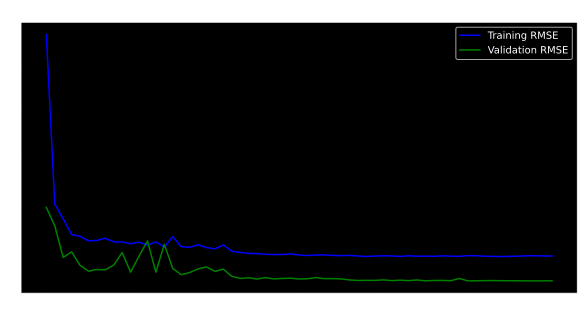

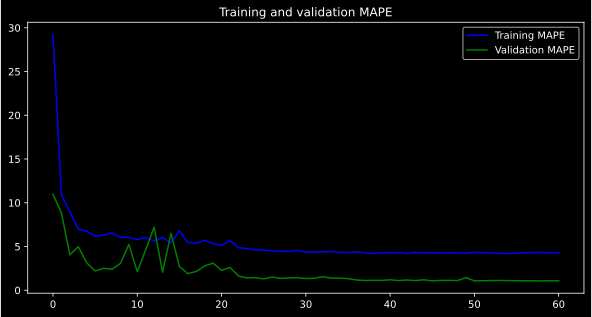

In [140]:
plot_history(history)

In [141]:
model.load_weights('../working/best_model.hdf5')
model.save('../working/nn_1.hdf5')

In [142]:
test_predict_tab = model.predict(X_test)
print("TEST MAPE:", mape(y_test, test_predict_tab[:,0]))

TEST MAPE: 15.07


In [143]:
sub_predict_tab = model.predict(X_sub)
sample_submission['price'] = np.exp(sub_predict_tab[:,0])-1
sample_submission.to_csv('tab_submission.csv', index=False)

### Tabular NN with cross-validation

In [144]:
model = Sequential()
model.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu"))
model.add(L.Dropout(0.35))
model.add(L.Dense(256, activation="relu"))
model.add(L.Dropout(0.1))
model.add(L.Dense(1, activation="linear"))
# Compile model
LR=0.01
optimizer = tf.keras.optimizers.Adam(lr=LR)
model.compile(loss='MAPE',optimizer=optimizer, metrics=[rmse()])

#### Cross-validation

In [145]:
submissions_tab = pd.DataFrame(0,columns=["sub_1"], index=sample_submission.sell_id)

mape_per_fold = []

kfold = KFold(n_splits=5, shuffle=True)

fold_no = 1

for train, test in kfold.split(X, y):
    print('-'*32)
    print(f'Training for fold {fold_no} ...')
    
    history = model.fit(train_data.drop(['price'], axis=1).iloc[train],
                        train_data['price'].iloc[train].values, 
                        batch_size=512,
                        epochs=200,
                        validation_data=(train_data.drop(['price'], axis=1).iloc[test], 
                                         train_data['price'].iloc[test]),
                        callbacks=callbacks_list,
                        verbose=0
                       )
     
    predict = model.predict(train_data.drop(['price'], axis=1).iloc[test])
    print('Test MAPE:', mape(train_data['price'].iloc[test].values, predict)/10)
    mape_per_fold.append(mape(train_data['price'].iloc[test].values,predict)/10)
    submissions_tab[f'sub_{fold_no}'] = np.exp(model.predict(X_sub)[:,0])-1                      
    fold_no += 1

print('-'*32)
print('Average scores for all folds:')
print(f'MAPE: {np.mean(mape_per_fold)} (+- {np.std(mape_per_fold)})')
print('-'*32)

--------------------------------
Training for fold 1 ...
Restoring model weights from the end of the best epoch.
Epoch 00088: early stopping
Test MAPE: 11.758
--------------------------------
Training for fold 2 ...
Restoring model weights from the end of the best epoch.
Epoch 00016: early stopping
Test MAPE: 11.841
--------------------------------
Training for fold 3 ...
Restoring model weights from the end of the best epoch.
Epoch 00016: early stopping
Test MAPE: 12.034
--------------------------------
Training for fold 4 ...
Restoring model weights from the end of the best epoch.
Epoch 00016: early stopping
Test MAPE: 11.534
--------------------------------
Training for fold 5 ...
Restoring model weights from the end of the best epoch.
Epoch 00030: early stopping
Test MAPE: 11.572
--------------------------------
Average scores for all folds:
MAPE: 11.747799999999998 (+- 0.18292993194116716)
--------------------------------


In [146]:
submissions_tab['cross'] = (submissions_tab.sum(axis=1))/len(submissions_tab.columns)
sample_submission['price'] = submissions_tab['cross'].values
sample_submission.to_csv('tab_cv_submission.csv', index=False)

## 9. Model 4: Multiple Inputs(Tab+NLP)

### Text preprocessing

In [147]:
work.description

0       Авто на бодром ходу.  Все работает отлично.  П...
1       Продажа от собственника, второй владелец, ПТС ...
2       Внимание! Только для клиентов AVILON Автомобил...
3       В комплекте зимние колёса. 27.07.2020 Замена п...
4       Отличный авто, 2011 года выпуска, кроме передн...
                              ...                        
8347    Продаётся любимица семьи. Автомобилем неактивн...
8348    В продаже автомобиль от компании АО ABTODOM, о...
8349    Машина в идеальном техническом состоянии. Обсл...
8350    Автомобиль приобретался новым у дилера Avilon ...
8351    ID: 38887\nКомплектация-Comfort\nГод выпуска в...
Name: description, Length: 8352, dtype: object

In [148]:
'''Creating lemmatizer and stopwords list'''

mystem = Mystem() 
russian_stopwords = stopwords.words("russian")

Installing mystem to /root/.local/bin/mystem from http://download.cdn.yandex.net/mystem/mystem-3.1-linux-64bit.tar.gz


In [149]:
'''Lemmatizing and cleaning text:'''

work.description = work.description.apply(lambda x:preprocess_text(x))
work.description

0       авто бодрый ход работать отлично электрика ход...
1       продажа собственник второй владелец птс оригин...
2       внимание клиент avilon автомобиль пробег предл...
3       комплект зимний кол са замена передний тормозн...
4       отличный авто год выпуск кроме передний левый ...
                              ...                        
8347    прод тся любимица семья автомобиль неактивно п...
8348    продажа автомобиль компания ао abtodom официал...
8349    машина идеальный технический состояние обслужи...
8350    автомобиль приобретаться новый дилер avilon ок...
8351    id комплектация comfort год выпуск птс г компл...
Name: description, Length: 8352, dtype: object

### Tokenizer

In [150]:
'''Setting tokenize parameters'''

#The maximum number of words to be used
MAX_WORDS = 100000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 256

In [151]:
'''Split data''' 

text_train = work.description.iloc[X_train.index]
text_test = work.description.iloc[X_test.index]
text_sub = work.description.iloc[X_sub.index]

In [152]:
'''Fitting tokenizer on text'''

tokenize = Tokenizer(num_words=MAX_WORDS)
tokenize.fit_on_texts(work.description)

print('Quantity of worlds:', len(tokenize.word_index))

Quantity of worlds: 16902


In [153]:
'''Tokens example'''

i=0
for key in tokenize.word_index:
    if i < 20:
        i+=1
        print(key, '->', tokenize.word_index[key])
    else:
        break       

автомобиль -> 1
система -> 2
пробег -> 3
задний -> 4
салон -> 5
сидение -> 6
весь -> 7
год -> 8
состояние -> 9
передний -> 10
машина -> 11
s -> 12
диск -> 13
комплект -> 14
дилер -> 15
новый -> 16
официальный -> 17
ваш -> 18
кредит -> 19
фара -> 20


In [154]:
'''Tokenizing text'''

text_train_sequences = sequence.pad_sequences(tokenize.
    texts_to_sequences(text_train), maxlen=MAX_SEQUENCE_LENGTH)
text_test_sequences = sequence.pad_sequences(tokenize.
    texts_to_sequences(text_test), maxlen=MAX_SEQUENCE_LENGTH)
text_sub_sequences = sequence.pad_sequences(tokenize.
    texts_to_sequences(text_sub), maxlen=MAX_SEQUENCE_LENGTH)

print(text_train_sequences.shape, text_test_sequences.shape, text_sub_sequences.shape, )

(5678, 256) (1003, 256) (1671, 256)


In [155]:
'''That's how our text looks now:'''

print(text_train.iloc[6])# original 
print(text_train_sequences[6])# tokenized

автомобиль проверять пункт автокредит специальный ставка ауди центр север официальный дилер audi входить группа компания рольф являться крупный дилер европа предлагать ряд услуга покупка продажа автомобиль пробег протяжение многий год наш дилерский центр являться лидер продажа автомобиль пробег среди весь дилер audi россия предоставлять клиент самый большой выбор автомобиль пробег audi марка каждый автомобиль проходить тщательный диагностика подготовка гарантировать находиться отличный состояние убеждаться правильный выбор возможность проходить тест драйв ознакомительный поездка интересовать автомобиль смочь ознакомляться автомобиль выходить дом наш менеджер проводить online презентация видеозвонок показывать выбирать автомобиль также ауди центр север представлять уникальный предложение кредитование автомобиль пробег индивидуальный условие специалист компания подбирать хороший условие кредитование проверенный автомобиль пробег гарантия год ждать сайт rolf probeg мобильный приложение ро

### RNN NLP

In [156]:
'''Tabular model from above'''

model_tab = Sequential()
model_tab.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu"))
model_tab.add(L.Dropout(0.35))
model_tab.add(L.Dense(256, activation="relu"))
model_tab.add(L.Dropout(0.1))

In [157]:
'''Nlp NN using LSTM'''

model_nlp = Sequential()
model_nlp.add(L.Input(shape=MAX_SEQUENCE_LENGTH, name="seq_description"))
model_nlp.add(L.Embedding(len(tokenize.word_index)+1, MAX_SEQUENCE_LENGTH,))
model_nlp.add(L.LSTM(256, return_sequences=True))
model_nlp.add(L.Dropout(0.3))
model_nlp.add(L.LSTM(128,))
model_nlp.add(L.Dropout(0.2))
model_nlp.add(L.Dense(64, activation="relu"))
model_nlp.add(L.Dropout(0.1))

### Multiple Inputs NN

In [158]:
'''Combining nets:'''

combinedInput = L.concatenate([model_nlp.output, model_tab.output])
# being our regression head
head = L.Dense(64, activation="relu")(combinedInput)
head = L.Dense(1, activation="linear")(head)

model = Model(inputs=[model_nlp.input, model_tab.input], outputs=head)
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
seq_description (InputLayer)    [(None, 256)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 256, 256)     4327168     seq_description[0][0]            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 256, 256)     525312      embedding[0][0]                  
__________________________________________________________________________________________________
dropout_6 (Dropout)             (None, 256, 256)     0           lstm[0][0]                       
_______________________________________________________________________________________

### Fit

In [159]:
optimizer = tf.keras.optimizers.Adam(0.0001)
model.compile(loss='MAPE',optimizer=optimizer, metrics=[rmse()])

In [160]:
checkpoint = ModelCheckpoint('best_model.hdf5' , monitor = ['val_loss'] ,
                              verbose = 0  , mode = 'min')

# Stop the education if the is no progress:
earlystop = EarlyStopping(monitor='val_loss', patience=10,verbose=1,mode='min',
                          restore_best_weights=True)

# Reduce learning rate if the is no progress:
reduce_lr = ReduceLROnPlateau( monitor='val_loss',factor=0.25,patience=3,
                               min_lr=1e-10,verbose=1,mode='min')

callbacks_list = [checkpoint, earlystop,reduce_lr]

In [161]:
history = model.fit([text_train_sequences, X_train], y_train,
                    batch_size=480,
                    epochs=45, 
                    validation_data=([text_test_sequences, X_test], y_test),
                    callbacks=callbacks_list,
                    verbose=0)                    


Epoch 00027: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.

Epoch 00036: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-06.

Epoch 00039: ReduceLROnPlateau reducing learning rate to 1.56249996052793e-06.

Epoch 00042: ReduceLROnPlateau reducing learning rate to 3.906249901319825e-07.
Restoring model weights from the end of the best epoch.
Epoch 00043: early stopping


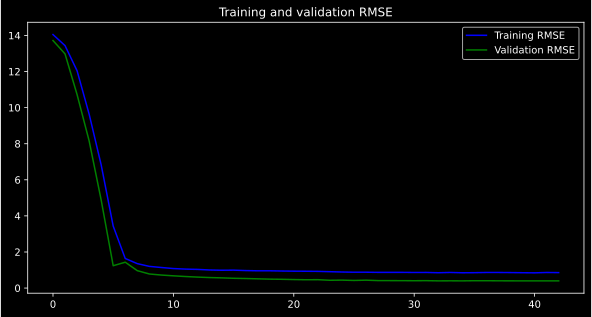

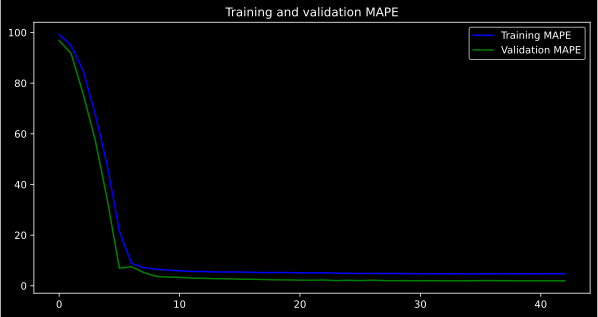

In [162]:
plot_history(history)

In [163]:
model.load_weights('../working/best_model.hdf5')
model.save('../working/rn_tab.hdf5')

In [164]:
test_predict_rn_tab = model.predict([text_test_sequences, X_test])
print('Test MAPE:', mape(y_test, test_predict_rn_tab[:,0]))

Test MAPE: 38.04


In [165]:
sub_predict_rn_tab = model.predict([text_sub_sequences, X_sub])
sample_submission['price'] = np.exp(sub_predict_rn_tab[:,0])-1
sample_submission.to_csv('rn_tab_submission.csv', index=False)

#### There are no enough data for LSTM, it needs pretty big corpus of text to work well. So, in next chapters I'll try to use another models.  

## 10. Model 5: Multiple Inputs(Convolutional NN + Tabular)

In [166]:
'''Conerting column to list:'''

desc_lists = work.description.apply(lambda x:x.split())
desc_lists

0       [авто, бодрый, ход, работать, отлично, электри...
1       [продажа, собственник, второй, владелец, птс, ...
2       [внимание, клиент, avilon, автомобиль, пробег,...
3       [комплект, зимний, кол, са, замена, передний, ...
4       [отличный, авто, год, выпуск, кроме, передний,...
                              ...                        
8347    [прод, тся, любимица, семья, автомобиль, неакт...
8348    [продажа, автомобиль, компания, ао, abtodom, о...
8349    [машина, идеальный, технический, состояние, об...
8350    [автомобиль, приобретаться, новый, дилер, avil...
8351    [id, комплектация, comfort, год, выпуск, птс, ...
Name: description, Length: 8352, dtype: object

In [167]:
'''Counting sentences lengths and quantity of unique worlds:'''

all_words = [word for tokens in desc_lists for word in tokens]
sentence_lengths = [len(tokens) for tokens in desc_lists]
VOCAB = sorted(list(set(all_words)))
print("%s words total, with a vocabulary size of %s" % (len(all_words), len(VOCAB)))
print("Max sentence length is %s" % max(sentence_lengths))

707781 words total, with a vocabulary size of 16902
Max sentence length is 912


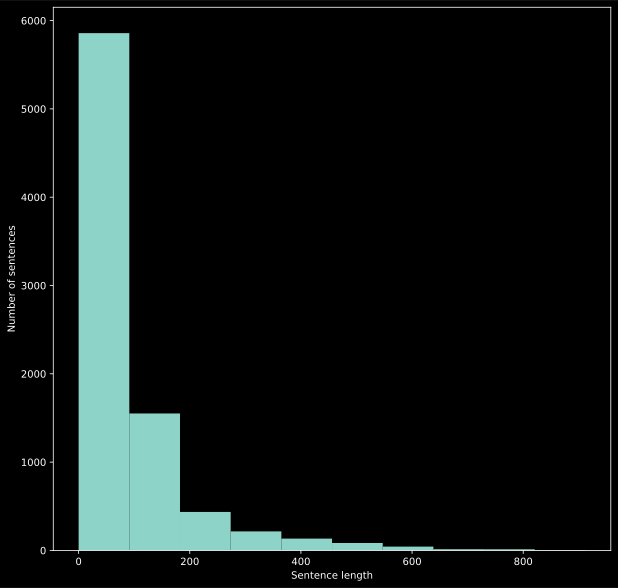

In [168]:
'''Let's look on the distribution of sentenses lengths:'''

fig = plt.figure(figsize=(10, 10)) 
plt.xlabel('Sentence length')
plt.ylabel('Number of sentences')
plt.hist(sentence_lengths)
plt.show()

#### As we can see, the are not much texts with length more than 200, but I'll use 300 to be sure. 

In [169]:
'''Creating embeddings for CNN'''

EMBEDDING_DIM = 300 
MAX_SEQUENCE_LENGTH = 300 # set by investigating the graph above
VOCAB_SIZE = len(VOCAB)


tokenize = Tokenizer(num_words=VOCAB_SIZE)# new tokenizer
tokenize.fit_on_texts(work.description.tolist())

text_train_sequences = sequence.pad_sequences(tokenize.
    texts_to_sequences(text_train), maxlen=MAX_SEQUENCE_LENGTH)
text_test_sequences = sequence.pad_sequences(tokenize.
    texts_to_sequences(text_test), maxlen=MAX_SEQUENCE_LENGTH)
text_sub_sequences = sequence.pad_sequences(tokenize.
    texts_to_sequences(text_sub), maxlen=MAX_SEQUENCE_LENGTH)

word_index = tokenize.word_index

embedding_weights = np.zeros((len(word_index)+1, EMBEDDING_DIM))
for word,index in word_index.items():# setting weights
    embedding_weights[index,:] = word2vec[word] if word in \
                                 word2vec else np.random.rand(EMBEDDING_DIM)
print(embedding_weights.shape)

(16903, 300)


In [170]:
checkpoint = ModelCheckpoint('best_model.hdf5' , monitor = ['val_loss'] ,
                              verbose = 0  , mode = 'min')

# Stop the education if the is no progress:
earlystop = EarlyStopping(monitor='val_loss', patience=10,verbose=1,mode='min',
                          restore_best_weights=True)

# Reduce learning rate if the is no progress:
reduce_lr = ReduceLROnPlateau( monitor='val_loss',factor=0.25,patience=3,
                               min_lr=1e-10,verbose=1,mode='min')

callbacks_list = [checkpoint, earlystop,reduce_lr]

In [171]:
'''Assembling covolutional network'''

model_cnn = Sequential()
model_cnn.add(L.Input(shape=MAX_SEQUENCE_LENGTH, dtype='int32'))
model_cnn.add(L.Embedding(len(word_index)+1, EMBEDDING_DIM,
                          weights=[embedding_weights],
                          input_length=MAX_SEQUENCE_LENGTH,
                          trainable=True))
model_cnn.add(L.Conv1D(filters=128, kernel_size=3, activation='relu'))
model_cnn.add(L.MaxPooling1D(pool_size=3))
model_cnn.add(L.Conv1D(filters=128, kernel_size=3, activation='relu'))
model_cnn.add(L.MaxPooling1D(pool_size=3))
model_cnn.add(L.Conv1D(filters=128, kernel_size=1, activation='relu'))
model_cnn.add(L.MaxPooling1D(pool_size=3))
model_cnn.add(L.Dropout(0.1))# prevent overfitting
model_cnn.add(L.Flatten())




In [172]:
combinedInput = L.concatenate([model_cnn.output, model_tab.output])
# being our regression head
head = L.Dense(64, activation="relu")(combinedInput)
head = L.Dense(1, activation="linear")(head)

model = Model(inputs=[model_cnn.input, model_tab.input], outputs=head)
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 300)]        0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 300, 300)     5070900     input_1[0][0]                    
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 298, 128)     115328      embedding_1[0][0]                
__________________________________________________________________________________________________
max_pooling1d (MaxPooling1D)    (None, 99, 128)      0           conv1d[0][0]                     
_______________________________________________________________________________________

In [173]:
optimizer = tf.keras.optimizers.Adam(0.0001)
model.compile(loss='MAPE',optimizer=optimizer, metrics=[rmse()])

In [174]:
history = model.fit([text_train_sequences, X_train], y_train,
                    batch_size=512,
                    epochs=50, 
                    validation_data=([text_test_sequences, X_test], y_test),
                    callbacks=callbacks_list,
                    verbose =0
                   )


Epoch 00031: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.

Epoch 00036: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-06.

Epoch 00042: ReduceLROnPlateau reducing learning rate to 1.56249996052793e-06.

Epoch 00045: ReduceLROnPlateau reducing learning rate to 3.906249901319825e-07.

Epoch 00048: ReduceLROnPlateau reducing learning rate to 9.765624753299562e-08.
Restoring model weights from the end of the best epoch.
Epoch 00049: early stopping


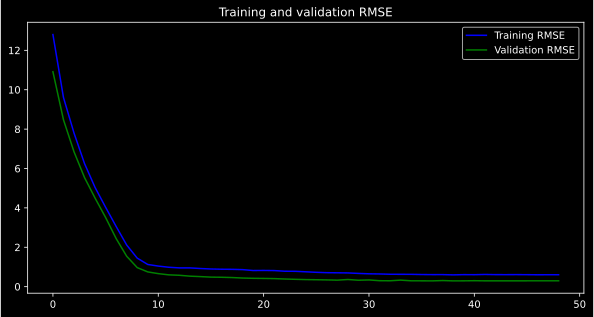

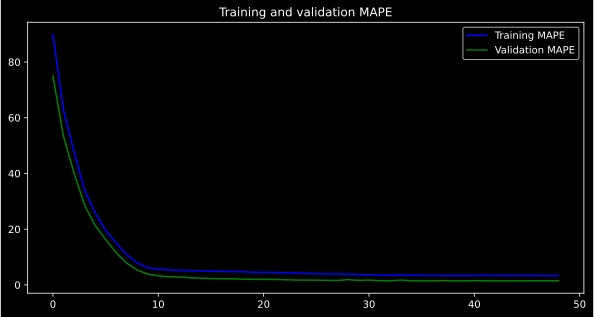

In [175]:
plot_history(history)

In [176]:
model.load_weights('../working/best_model.hdf5')
model.save('../working/cnn_nlp.hdf5')

In [177]:
test_predict_cn_tab = model.predict([text_test_sequences, X_test])
print('Test MAPE:', mape(y_test, test_predict_cn_tab[:,0]))

Test MAPE: 23.05


In [178]:
sub_predict_cn_tab = model.predict([text_sub_sequences, X_sub])
sample_submission['price'] = np.exp(sub_predict_cn_tab[:,0])-1
sample_submission.to_csv('cn_tab_submission.csv', index=False)

## 11. Model 6: BERT

In [179]:
'''Loading and setting BERT transformer:'''

model_name = 'Geotrend/bert-base-ru-cased'

max_length = 300# set as above

# load settings and set output_hidden_states - False
config = BertConfig.from_pretrained(model_name)
config.output_hidden_states = False

# Loading the Bert tokenizer
tokenizer = BertTokenizerFast.from_pretrained(pretrained_model_name_or_path = model_name,
                                              config = config)

# Loading model
transformer_model = TFBertModel.from_pretrained(model_name, config = config)

Some layers from the model checkpoint at Geotrend/bert-base-ru-cased were not used when initializing TFBertModel: ['mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at Geotrend/bert-base-ru-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [180]:
'''Defining data'''

X_bert = work_b.description[work_b['sample']==1]
y_bert = work_b.price[work_b['sample']==1].values
X_sub_bert = work_b.description[work_b['sample']==0]

X_bert

0       Авто на бодром ходу.  Все работает отлично.  П...
1       Продажа от собственника, второй владелец, ПТС ...
2       Внимание! Только для клиентов AVILON Автомобил...
3       В комплекте зимние колёса. 27.07.2020 Замена п...
4       Отличный авто, 2011 года выпуска, кроме передн...
                              ...                        
6676    Продаётся любимый автомобиль! За годы эксплуат...
6677    Куплена у официального дилера в 2017 г. \n\nТр...
6678    Торг на месте. Все работает. Сборка немецкая. ...
6679    Автомобиль в отличном состоянии.\n3-из Авто в ...
6680    Удлиненный заводской Pullman на базе W140 (воо...
Name: description, Length: 6681, dtype: object

In [181]:
X_train_b,X_test_b,y_train_b,y_test_b = train_test_split(X_bert,y_bert, 
                                                         test_size=0.15,
                                                         shuffle=True, 
                                                         random_state=RANDOM_SEED)

In [182]:
'''Tokenizing data wth BERT tokenizer'''

X_train_b= tokenizer(
    text=X_train_b.to_list(),
    add_special_tokens=True,
    max_length=max_length,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = True,
    return_attention_mask = True,
    verbose = False)   

X_test_b= tokenizer(
    text=X_test_b.to_list(),
    add_special_tokens=True,
    max_length=max_length,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = True,
    return_attention_mask = True,
    verbose = False)   

X_sub_b = tokenizer(
    text=X_sub_bert.to_list(),
    add_special_tokens=True,
    max_length=max_length,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = True,
    return_attention_mask = True,
    verbose = False)  


In [183]:
'''Assembling model'''

bert = transformer_model.layers[0]# BERT layer

# Input data
input_ids = L.Input(shape=(max_length,), name='input_ids', dtype='int32')
mask = L.Input((max_length,),name='mask', dtype=tf.int32)
tti = L.Input((max_length,),name = 'token_type', dtype=tf.int32)     
inputs = {'input_ids': input_ids,
          'token_type_ids': tti,
          'attention_mask': mask}      
# oad the BERT model as a keras layer
bert_model = bert(inputs)[1]
dropout = L.Dropout(0.3)
drop_output = dropout(bert_model)
price = L.Dense(1, activation = 'linear',
              kernel_initializer=TruncatedNormal(stddev=config.initializer_range), 
              name='price')(drop_output)
outputs = {'price': price}

model_bert = Model(inputs=inputs, outputs=outputs, name='BERT')
model_bert.summary()

Model: "BERT"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
mask (InputLayer)               [(None, 300)]        0                                            
__________________________________________________________________________________________________
input_ids (InputLayer)          [(None, 300)]        0                                            
__________________________________________________________________________________________________
token_type (InputLayer)         [(None, 300)]        0                                            
__________________________________________________________________________________________________
bert (TFBertMainLayer)          TFBaseModelOutputWit 97010688    mask[0][0]                       
                                                                 input_ids[0][0]               

In [184]:
'''Compiling model'''

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-03,
                                     epsilon=1e-08,
                                     decay=0.01,
                                     clipnorm=1.0)                            
loss = {'price': MAPE_()}# loss function
model_bert.compile(optimizer = optimizer,loss = loss, metrics=[rmse()])

In [185]:
# Stop the education if the is no progress:
earlystop = EarlyStopping(monitor='val_loss', patience=10,verbose=1,mode='min',
                          restore_best_weights=True)

# Reduce learning rate if the is no progress:
reduce_lr = ReduceLROnPlateau( monitor='val_loss',factor=0.25,patience=3,
                               min_lr=1e-10,verbose=1,mode='min')

callbacks_list = [earlystop,reduce_lr]

In [186]:
history = model_bert.fit(
    {'input_ids': X_train_b['input_ids'],
     'token_type_ids': X_train_b['token_type_ids'],
     'attention_mask': X_train_b['attention_mask']},
    {'price': y_train_b},
    batch_size=20,
    epochs=15,
    validation_data=({'input_ids': X_test_b['input_ids'],
                      'token_type_ids': X_test_b['token_type_ids'],
                      'attention_mask': X_test_b['attention_mask']},
    {'price': y_test_b}),
    callbacks=callbacks_list,
    verbose =1)

Epoch 1/15
284/284 [==============================] - 223s 787ms/step - loss: 7.9561 - root_mean_squared_error: 2.8538 - val_loss: 4.2915 - val_root_mean_squared_error: 0.7741
Epoch 2/15
284/284 [==============================] - 220s 775ms/step - loss: 4.7820 - root_mean_squared_error: 0.8551 - val_loss: 4.3210 - val_root_mean_squared_error: 0.7846
Epoch 3/15
284/284 [==============================] - 220s 775ms/step - loss: 4.7424 - root_mean_squared_error: 0.8495 - val_loss: 4.3085 - val_root_mean_squared_error: 0.7591
Epoch 4/15
284/284 [==============================] - 221s 777ms/step - loss: 4.7641 - root_mean_squared_error: 0.8463 - val_loss: 4.2847 - val_root_mean_squared_error: 0.7708
Epoch 5/15
284/284 [==============================] - 220s 775ms/step - loss: 4.7271 - root_mean_squared_error: 0.8454 - val_loss: 4.2857 - val_root_mean_squared_error: 0.7604
Epoch 6/15
284/284 [==============================] - 220s 775ms/step - loss: 4.7220 - root_mean_squared_error: 0.8448 -

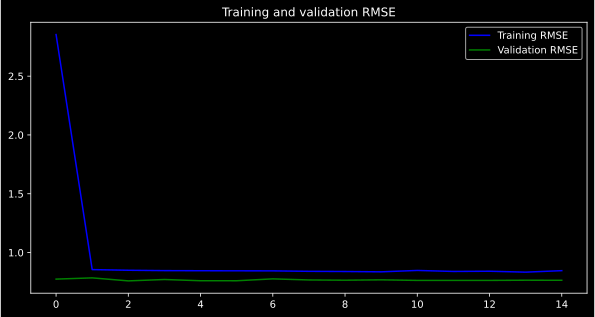

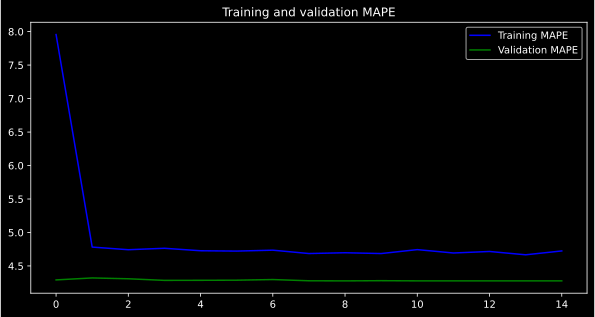

In [187]:
plot_history(history)

In [188]:
test_predict_bert = model_bert.predict(x={'input_ids': X_test_b['input_ids'],
                      'token_type_ids': X_test_b['token_type_ids'],
                      'attention_mask': X_test_b['attention_mask']})
print('Test MAPE:', mape(y_test_b, list(test_predict_bert.values())[0]))

Test MAPE: 63.09


In [190]:
sub_predict_bert = model_bert.predict(x={'input_ids': X_sub_b['input_ids'],
                      'token_type_ids': X_sub_b['token_type_ids'],
                      'attention_mask': X_sub_b['attention_mask']})
sample_submission['price'] = np.exp(list(sub_predict_bert.values())[0])-1
sample_submission.to_csv('bert_submission.csv', index=False)

#### I think that there is some mistake in preferences, because this model must show better results.

## 12. Model 7: Final model(Computer vision+Convolutional+Tabular)

### Data

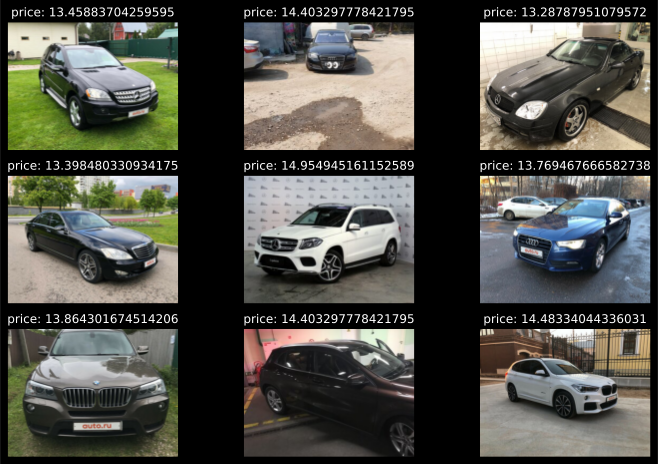

In [191]:
'''Make sure that the prices and photos have been loaded correctly'''

plt.figure(figsize = (12,8))

random_image = work[work['sample'] == 1].sample(n = 9)
random_image_paths = random_image['sell_id'].values
random_image_cat = random_image['price'].values

for index, path in enumerate(random_image_paths):
    im = PIL.Image.open(DATA_DIR+'img/img/' + str(path) + '.jpg')
    plt.subplot(3, 3, index + 1)
    plt.imshow(im)
    plt.title('price: ' + str(random_image_cat[index]))
    plt.axis('off')
plt.show()

In [192]:
size = (320, 240)# image size for model 

images_train = get_image_array(X_train.index)
images_test = get_image_array(X_test.index)
images_sub = get_image_array(X_sub.index)

images shape (5678, 240, 320, 3) dtype uint8
images shape (1003, 240, 320, 3) dtype uint8
images shape (1671, 240, 320, 3) dtype uint8


### albumentations

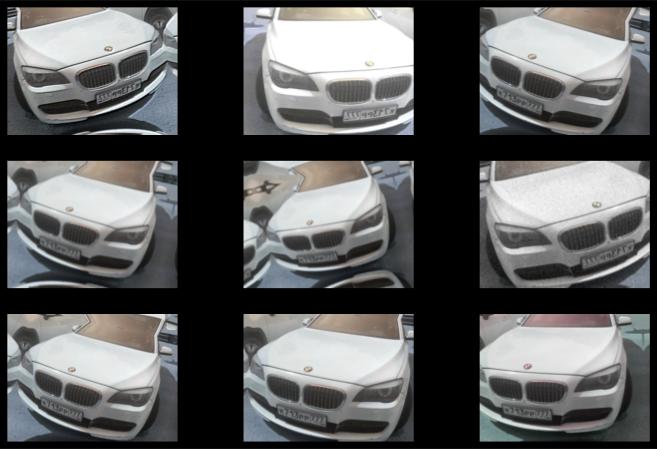

In [193]:
augmentation = Compose([
    HorizontalFlip(),
    OneOf([
        IAAAdditiveGaussianNoise(),
        GaussNoise(),
    ], p=0.2),
    OneOf([
        MotionBlur(p=0.2),
        MedianBlur(blur_limit=3, p=0.1),
        Blur(blur_limit=3, p=0.1),
    ], p=0.2),
    ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=15, p=1),
    OneOf([
        OpticalDistortion(p=0.3),
        GridDistortion(p=0.1),
        IAAPiecewiseAffine(p=0.3),
    ], p=0.2),
    OneOf([
        CLAHE(clip_limit=2),
        IAASharpen(),
        IAAEmboss(),
        RandomBrightnessContrast(),
    ], p=0.3),
    HueSaturationValue(p=0.3),
], p=1)

# Example
plt.figure(figsize = (12,8))
for i in range(9):
    img = augmentation(image = images_train[0])['image']
    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

In [194]:
'''Using tf.dataset to send data to model:'''

train_dataset = tf.data.Dataset.from_tensor_slices((
    images_train, X_train, work.description.iloc[X_train.index], y_train
    )).map(tf_process_train_dataset_element)

test_dataset = tf.data.Dataset.from_tensor_slices((
    images_test, X_test, work.description.iloc[X_test.index], y_test
    )).map(tf_process_val_dataset_element)

y_sub = np.zeros(len(X_sub))
sub_dataset = tf.data.Dataset.from_tensor_slices((
    images_sub, X_sub, work.description.iloc[X_sub.index], y_sub
    )).map(tf_process_val_dataset_element)

# Checking for mistakes:
train_dataset.__iter__().__next__();
test_dataset.__iter__().__next__();
sub_dataset.__iter__().__next__();

In [195]:
'''Load EfficientNet to work with images:'''

efficientnet_model = efn.EfficientNetB6(weights='imagenet', 
                                        include_top=False,
                                        input_shape = (size[1],size[0], 3))
# EF wiil not be trainable in the beginning for Fine-tuning:
efficientnet_model.trainable = False
efficientnet_output = L.GlobalAveragePooling2D()(efficientnet_model.output)

165527552/165527152 [==============================] - 3s 0us/step


In [196]:
'''Assemling NN model from 3 previous models: '''

combinedInput = L.concatenate([efficientnet_output,
                               model_tab.output, 
                               model_cnn.output])# this model showed best result

# Head
dropout = L.Dropout(0.2)
drop_output = dropout(combinedInput)
head = L.Dense(256, activation="relu")(drop_output)
head = L.Dense(1,activation="linear")(head)

model = Model(inputs=[efficientnet_model.input,
                      model_tab.input,
                      model_cnn.input],
              outputs=head)


In [197]:
optimizer = tf.keras.optimizers.Adam(0.001)
model.compile(loss='MAPE',optimizer=optimizer, metrics=[rmse()])

In [199]:
checkpoint = ModelCheckpoint('best_model.hdf5' , monitor = ['val_loss'] ,
                              verbose = 0  , mode = 'min')

earlystop = EarlyStopping(monitor='val_loss', patience=10,verbose=1,mode='min',
                          restore_best_weights=True)

reduce_lr = ReduceLROnPlateau( monitor='val_loss',factor=0.25,patience=3,
                               min_lr=1e-10,verbose=1,mode='min')

callbacks_list = [checkpoint, earlystop,reduce_lr]

### Fine-tuning 

### Step 1

In [198]:
history = model.fit(train_dataset.batch(30),
                    epochs=10,
                    validation_data = test_dataset.batch(30),
                    callbacks=callbacks_list,
                    verbose = 1
                   )

Epoch 1/10
190/190 [==============================] - 87s 459ms/step - loss: 214.8983 - root_mean_squared_error: 201.7670 - val_loss: 7.3372 - val_root_mean_squared_error: 1.1566
Epoch 2/10
190/190 [==============================] - 86s 454ms/step - loss: 8.9342 - root_mean_squared_error: 4.4441 - val_loss: 3.3221 - val_root_mean_squared_error: 0.5445
Epoch 3/10
190/190 [==============================] - 84s 443ms/step - loss: 6.9585 - root_mean_squared_error: 2.6163 - val_loss: 6.9929 - val_root_mean_squared_error: 1.0425
Epoch 4/10
190/190 [==============================] - 85s 449ms/step - loss: 7.6993 - root_mean_squared_error: 5.5719 - val_loss: 8.0565 - val_root_mean_squared_error: 1.1884
Epoch 5/10
190/190 [==============================] - 87s 456ms/step - loss: 5.7970 - root_mean_squared_error: 2.0752 - val_loss: 2.5595 - val_root_mean_squared_error: 0.4123
Epoch 6/10
190/190 [==============================] - 81s 429ms/step - loss: 6.7929 - root_mean_squared_error: 4.8147 - v

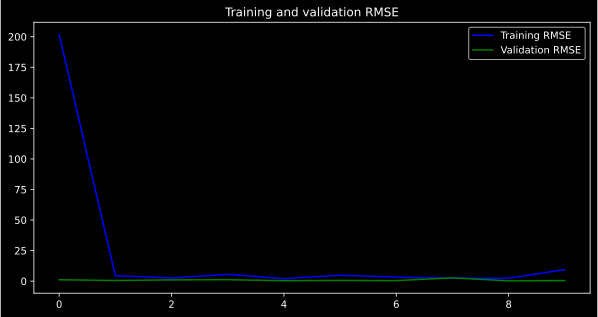

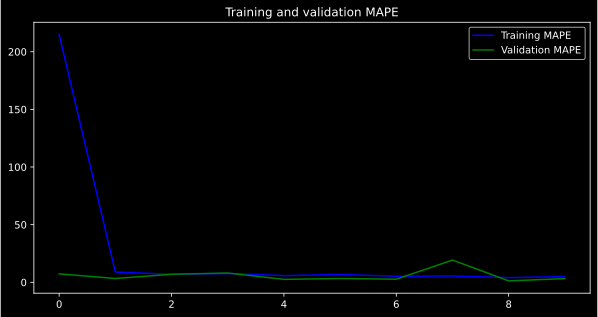

In [200]:
plot_history(history)


In [201]:
model.load_weights('../working/best_model.hdf5')
model.save('../working/nn_final.hdf5')

ValueError: You are trying to load a weight file containing 8 layers into a model with 366 layers.

In [202]:
test_predict_st1 = model.predict(test_dataset.batch(30))
print('Test MAPE:', mape(y_test, test_predict_st1[:,0]))

Test MAPE: 35.28


### Step 2

In [203]:
'''On this step we'll make half of efn layers trainable ''' 

efficientnet_model.trainable = True
print("Number of layers in the efn model: ", len(efficientnet_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = len(efficientnet_model.layers)//2

# Freeze all the layers before the `fine_tune_at` layer
for layer in efficientnet_model.layers[:fine_tune_at]:
    layer.trainable =  False

print("Number of trainable layers: ",len(efficientnet_model.trainable_variables))

Number of layers in the efn model:  659
Number of trainable layers:  291


In [204]:
optimizer = tf.keras.optimizers.Adam(0.0001)
model.compile(loss='MAPE',optimizer=optimizer, metrics=[rmse()])

In [205]:
history = model.fit(train_dataset.batch(30),
                    epochs=15,
                    validation_data = test_dataset.batch(30),
                    callbacks=callbacks_list,
                    verbose = 1
                   )

Epoch 1/15
190/190 [==============================] - 111s 583ms/step - loss: 2.3533 - root_mean_squared_error: 0.4240 - val_loss: 1.1805 - val_root_mean_squared_error: 0.2220
Epoch 2/15
190/190 [==============================] - 107s 561ms/step - loss: 2.3927 - root_mean_squared_error: 0.4365 - val_loss: 1.9088 - val_root_mean_squared_error: 0.3338
Epoch 3/15
190/190 [==============================] - 105s 550ms/step - loss: 2.4170 - root_mean_squared_error: 0.4344 - val_loss: 1.2353 - val_root_mean_squared_error: 0.2319
Epoch 4/15
190/190 [==============================] - ETA: 0s - loss: 2.2946 - root_mean_squared_error: 0.4160
Epoch 00004: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
190/190 [==============================] - 107s 563ms/step - loss: 2.2946 - root_mean_squared_error: 0.4160 - val_loss: 1.2807 - val_root_mean_squared_error: 0.2399
Epoch 5/15
190/190 [==============================] - 108s 568ms/step - loss: 2.2383 - root_mean_squared_error: 0.40

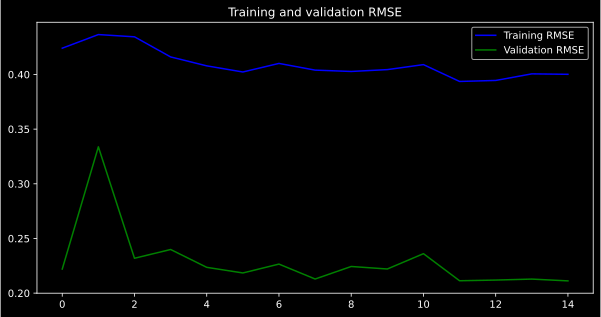

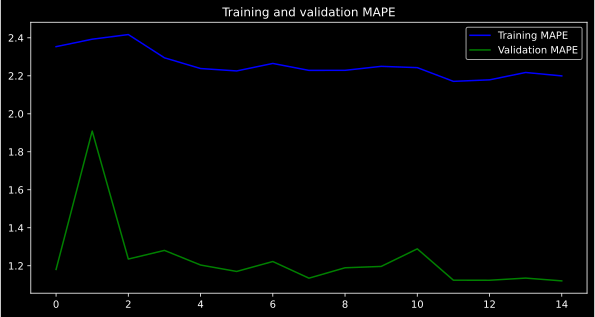

In [206]:
plot_history(history) 

In [ ]:
model.load_weights('../working/best_model.hdf5')
model.save('../working/nn_final.hdf5')

### Step 3

In [207]:
'''Making all layers trainable:'''

for layer in model.layers:
    layer.trainable =  True
print("Number of layers in the efn model: ", len(efficientnet_model.layers))    
print("Number of trainable layers: ",len(efficientnet_model.trainable_variables))    

Number of layers in the efn model:  659
Number of trainable layers:  582


In [208]:
optimizer = tf.keras.optimizers.Adam(0.0001)
model.compile(loss='MAPE',optimizer=optimizer, metrics=[rmse()])

Epoch 1/20
568/568 [==============================] - 287s 506ms/step - loss: 2.6099 - root_mean_squared_error: 0.4685 - val_loss: 5.5011 - val_root_mean_squared_error: 0.8013
Epoch 2/20
568/568 [==============================] - 283s 499ms/step - loss: 2.5719 - root_mean_squared_error: 0.4614 - val_loss: 1.3229 - val_root_mean_squared_error: 0.2390
Epoch 3/20
568/568 [==============================] - 283s 499ms/step - loss: 2.4246 - root_mean_squared_error: 0.4388 - val_loss: 1.3969 - val_root_mean_squared_error: 0.2486
Epoch 4/20
568/568 [==============================] - 284s 499ms/step - loss: 2.3725 - root_mean_squared_error: 0.4285 - val_loss: 1.1267 - val_root_mean_squared_error: 0.2138
Epoch 5/20
568/568 [==============================] - 283s 499ms/step - loss: 2.4692 - root_mean_squared_error: 0.4440 - val_loss: 1.5370 - val_root_mean_squared_error: 0.2662
Epoch 6/20
568/568 [==============================] - 283s 499ms/step - loss: 2.3690 - root_mean_squared_error: 0.4255 -

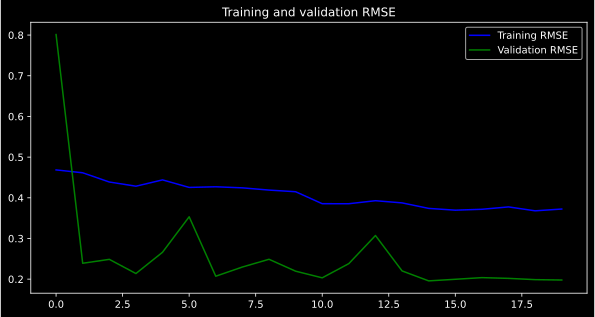

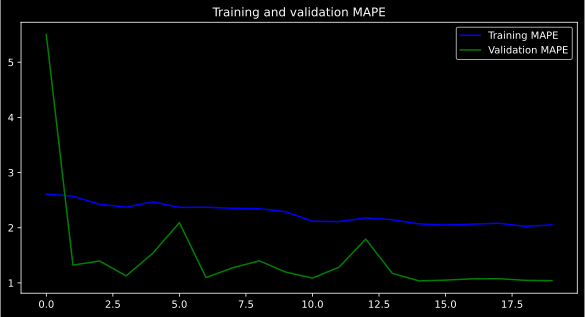

In [210]:
history = model.fit(train_dataset.batch(10),
                    epochs=20,
                    validation_data = test_dataset.batch(10),
                    callbacks=callbacks_list,
                    verbose = 1
                   )
plot_history(history)

In [211]:
model.load_weights('../working/best_model.hdf5')
model.save('../working/nn_final.hdf5')
test_predict_final = model.predict(test_dataset.batch(30))
print('Test MAPE:', mape(y_test, test_predict_final[:,0]))

Test MAPE: 14.43


In [212]:
sub_predict_final = model.predict(sub_dataset.batch(30))
sub_predict_final = np.exp(sub_predict_final[:,0])-1
sample_submission['price'] = sub_predict_final
sample_submission.to_csv('final_submission.csv', index=False)

## 13. Blending models submissions

In [218]:
blend_predict_cat_fin = (test_predict_cat*0.7 + test_predict_final[:,0]*0.3)
print('Test MAPE:', mape(y_test, blend_predict_cat_fin))

Test MAPE: 12.71


In [219]:
blend_sub_predict_cat_fin = 0.7*sub_predict_catboost + 0.3*sub_predict_final
sample_submission['price'] = (blend_sub_predict_cat_fin.round(2)/1000).round(2)*1000
sample_submission.to_csv('blend_cat_fin_submission.csv', index=False)

In [220]:
sample_submission

sell_id     price
0     1099427284  160040.0
1     1096405886  829420.0
2     1100195294  185630.0
3     1099827282  150500.0
4     1100076198  825880.0
...          ...       ...
1666  1099414488  322320.0
1667  1099277058  597090.0
1668  1098773964  403520.0
1669  1098835932  286980.0
1670  1099834690  271980.0

[1671 rows x 2 columns]

In [223]:


test_mape = {'Naïve':18.85,'CatBoost':13.12,'CatBoost with kfold':12.94,
'Tabular NN':15.07,'Tabular NN with kfold':11.75,'LSTM NLP + Tabular':38.04,             
'CNN NLP + Tabular':23.05,'BERT transformer':63.09,"CV + TAB + CNN(final)":14.43 ,
"Blend Catboost + final": 12.71}
sub_mape = {'Naïve':'','CatBoost':12.95,'CatBoost with kfold':12.93,
'Tabular NN':19.7,'Tabular NN with kfold':14.19,'LSTM NLP + Tabular':33.02,             
'CNN NLP + Tabular':24.44,'BERT transformer':60.64,"CV + TAB + CNN(final)": 14.64,
"Blend Catboost + final": 12.63}

In [246]:
'''Putting results into a dictionary'''

mape_dict = {'Test':[18.85,13.12,12.94,15.07,11.75,38.04, 23.05,63.09,14.43,12.71],
             'Sub':['',12.95,12.93,19.72,14.19,33.02,24.44,60.64,14.64,12.63]}
ind =  ['Naïve','CatBoost','CatBoost with kfold','Tabular NN',
        'Tabular NN with kfold','LSTM NLP + Tabular','CNN NLP + Tabular',
        'BERT transformer',"CV + TAB + CNN(final)","Blend Catboost + final"]

## Conclusion

#### During this work I have used several methods to make predictions. The best result was get by blending Catboost and Multiinput NN(CV + TAB + CNN) predicts. We can see the table below where all of the results are presented:

In [247]:
pd.DataFrame(mape_dict,index = ind)

Test    Sub
Naïve                   18.85       
CatBoost                13.12  12.95
CatBoost with kfold     12.94  12.93
Tabular NN              15.07  19.72
Tabular NN with kfold   11.75  14.19
LSTM NLP + Tabular      38.04  33.02
CNN NLP + Tabular       23.05  24.44
BERT transformer        63.09  60.64
CV + TAB + CNN(final)   14.43  14.64
Blend Catboost + final  12.71  12.63

#### As we can see the best result on submission was shown by  Catboost + final by Blending. As for NLP models, the best result has a Convolutional network. I've said above that there are not enough data for LSTM and something wrong with BERT properties.
#### Nevertheless, I've improved my skills in text preprocessing and assembling neural networks. As for BERT, I will spend more time to learn this model better, because this is a stae-of-the-art method and DataScientist must know how to use it, if he wants to keep up with the times.     